In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json

#**1.**

Escribir un programa en python en el que ingresada la profundidad máxima, cálcule punto a punto la variación de presión con la profundidad. Para ello el usuario deberá definir un valor máximo y en metros y el programa deberá retornar la grafica de Presión como función de y.

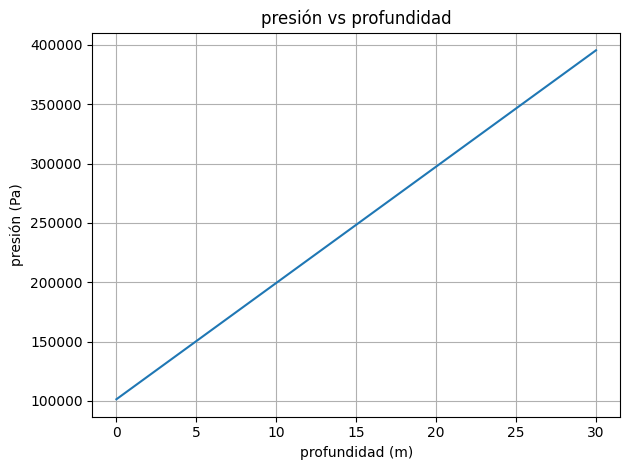

In [ ]:
density = 1000 # kg/m^3
max_depth = 30 # m
atm = 101325 # pascals
g = 9.807 #m/s^2

Pressure = lambda depth : atm + depth*g*density

x = np.linspace(0, max_depth, 100)
y = Pressure(x)


fig, ax = plt.subplots(1, 1, layout="tight")

ax.set_title('presión vs profundidad')
ax.set_xlabel('profundidad (m)')
ax.set_ylabel('presión (Pa)')

ax.plot(x,y) # trayectory plot

ax.grid(True)


#**2.**

Un jugador de baloncesto decide lanzar su balón a una distancia d del aro, con una rapidez v y ángulo theta respecto a la horizontal. Si la cesta tiene una altura de 3m, y el movimiento que realiza la pelota es un movimiento parabólico, construya un programa que determine si el jugador de baloncesto encesto o no encesto.

$$
bh = h + v_y(0)t - {g\over 2} t^2\\
t = {v_y(0) + \sqrt{v_y(0)^2+2g(h-bh)} \over g}
$$

#**Nota**

Para usar el programa se debe definir una variable de tipo `shootingfunction` de la siguiente manera:
```python
mivariable = shootingfunction()
```

 Esta variable guarda como atributos los valores que son constantes para cualquier tiro como por ejemplo: la gravedad, altura de la canasta y radio de la misma.

Para construir el prgrama definí una clase `shootingfunction`. Dicha clase contiene el método `fromjson` que toma como argumento un diccionario con los datos de tiro y a partir de ellos grafica la trayectoria y retorna un valor de tipo `bool` que indica si encestó o no.

El diccionario que guarda los datos debe tener obligatoriamente las claves `'theta'`, `'vo'` y `'d'`, también como datos opcionales puede tener la clave `'h'` que representa la altura de salida del disparo y la clave`'deg'` que indica si el ángulo está en grados (si el diccionario no incluye esta clave entonces el programa asume que el ángulo está en radianes).

Diccionario de ejemplo:
```python
datos_de_tiro = {
"vo" : 7.3,  # m/s
"d" : 4,     # m
"theta": 45, # deg

#optional keys
"h" : 1.95,  # m
"deg": True  
}
```

La clase también incluye los métodos `setgravity()`, `setradius()` y `setheight()` que sirven para modificar respectivamente los valores de gravedad, radio de la canasta y altura de la canasta guardados en `mivariable`, además de contener también el método `plotshoot()` que no retorna ningún valor y se limita a generar una gráfica de la trayectoria.

In [1]:
class shootingfunction:
    def __init__(self):
        # some constants we will use during shoots
        self.gravity       = 9.807  #gravity acceleration
        self.basket_radius = 0.225  #basket radius
        self.basket_height = 3      #basket height


    def setgravity(self, gravity):
        self.gravity = gravity


    def setradius(self, radius):
        self.basket_radius = radius


    def setheight(self, height):
        self.basket_height = height


    def fromjson(self, data): # function to allow score() to take a json file as an argument

        # obligatory arguments:
        shootspeed = data['vo']     #initial speed
        distocourt = data['d']      #horizontal distance from shooting point to center of the basket
        shootangle = data['theta']  #shooting angle

        #optional arguments:
        try:
            height = data['h']      #shooting height
        except:
            height = 1.95

        try:
            if data['deg']:         #True if angle is given in degrees
                shootangle *= np.pi/180
        except:
            pass

        return self.score(h = height, v_0 = shootspeed, theta = shootangle, d = distocourt)


    def score(self, h, v_0, theta, d, plot = True):

        # h     : shooting point height
        # v_0   : initial speed
        # theta : shooting angle
        # d     : horizontal distance from shooting point to center of the basket

        v_x0 = np.cos(theta)*v_0 # initial speend on x axis
        v_y0 = np.sin(theta)*v_0 # initial speed on y axis

        time_to_fsr = (d - self.basket_radius)/v_x0 # fsr stands for front side of the rim
        time_to_rsr = (d + self.basket_radius)/v_x0 # rsr stands for rear side of the rim

        H = lambda t : h + v_y0 * t - (self.gravity/2) * t**2 # height of the ball at a time t

        # using the intermediate value theorem we determine if H(t) = bh has a real solution for a t when the ball is near the rim
        # also by defining score this way we make sure it scores only if the ball is falling.
        score = H(time_to_fsr) > self.basket_height and H(time_to_rsr) < self.basket_height

        if plot:
            self.plotshoot(h, v_0, theta, d, prev_calculations = (score, v_x0, v_y0, H)) #method to plot the shoot

        return score


    def plotshoot(self, h, v_0, theta, d, prev_calculations = None):

        # if this method is called from the score() method, there are some calculations already made that we can use
        if not (prev_calculations is None):
            did_score, v_x0, v_y0, H = (data for data in prev_calculations)
        else:
            self.score(h, v_0, theta, d, plot = True)
            return None

        # time_to_y finds the tame it takes to the ball to get to the height y.
        time_to_y = lambda y : (v_y0 + (v_y0**2 + 2*self.gravity*(h - y))**(1/2)) / self.gravity

        # finish_time gives us the last moment of the trajectory that we will graph.
        # did score is a bool variable,
        finish_time = time_to_y(self.basket_height * did_score)

        X = lambda t : t * v_x0 # distance of the ball along the x axis at a time t


        figsize_x = 0.7*X(finish_time) + 2.1
        figsize_y = 4.9

        fig, ax = plt.subplots(1, 1, layout = "tight", figsize = (figsize_x, figsize_y))

        ax.set_title('Trayectoria del tiro')
        ax.set_xlabel('distancia horizontal (m)')
        ax.set_ylabel('eje de altura (m)')

        ## trayectory plot
        time = np.linspace(0,finish_time, 100)
        dist = X(time)
        y    = H(time)
        ax.plot(dist,y)

        ## rim sketch
        rim_front  = d-self.basket_radius
        rim_back   = d+self.basket_radius
        rim        = np.linspace(rim_front, rim_back,3)
        rim_height = np.full(3, self.basket_height)
        ax.plot(rim, rim_height)

        ax.plot(0,h,"ro") # shooting point

        ax.legend(['trayectoria','canasta','punto de lanzamiento'])
        ax.grid(True)

        ax.set_xticks(np.arange(0,X(finish_time)+1,1))
        ax.set_yticks(np.array([0,1,2,3,4,5]))

In [ ]:
# test json file for example of the next cell
test_shoot_file = json.dumps({
    "h" : 1.95,  # m #optional key
    "vo" : 7.3,  # m/s
    "d" : 4,     # m
    "theta": 45, # deg
    "deg": True
    })


with open('test_shoot.json','w') as f:
    f.write(test_shoot_file)

# Ejemplo de uso de la función:

```python
# leemos el archivo con los datos de tiro
with open('test_shoot.json') as f:
    test_shoot = json.load(f)


# definimos shoot como un objeto "shootingfunction"
shoot = shootingfunction()


# el método fromjson() retorna True si el jugador hace una cesta
shoot.fromjson(test_shoot)

<<< True

```

¡¡El jugador encestó!!

Aquí está una representación de la trayectoria:


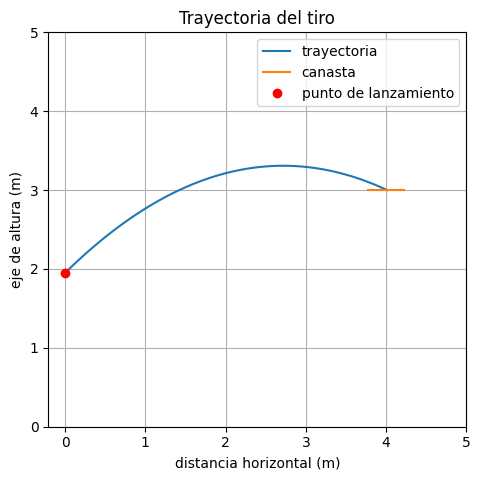

In [ ]:
with open('test_shoot.json') as f:
    test_shoot = json.load(f)


shoot = shootingfunction()
hizo_cesta = shoot.fromjson(test_shoot)


if hizo_cesta:
    print('¡¡El jugador encestó!!\n\nAquí está una representación de la trayectoria:')
else:
    print('disparo fallido\n\nAquí está una representación de la trayectoria:')